<a href="https://colab.research.google.com/github/anushkachougule/Exploratory-Data-Analysis-Hotel-Booking-Demand-Dataset/blob/main/CHOUGULE_INST627_Fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hotel-booking-demand:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F511638%2F944030%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240126%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240126T222636Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D760d061bc82e6d032bd9485760797feb055ebc14eed243376a8c5ce7c65059dc70b62a035fe0bf224bd4897e0c3e9e9133fc8151a1f32e9caecebd63ea8843c58c5b49447bda9b764c20d989166a59dea1d470541e8f1b35de6b7d5b57a70aec35c13dd8ad4d0832775fe8487fd4d686570bd3e154211e6336040cf2c94c723be49913620f2a9261dc13d8bbf4ec5e3578c6074a91f318ece25567cc44878c5fbee7fa47f0bac250d98cc009edfbec75abe89e66b7cb14df91a021e44bee170d5a7cef7012b573c962e012c799b1d45b92df72b6e5b6b8618941015485d55ad25cf642d1258f88671356627a291bd227730f31948126521c2568f8691ab2a191'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1308365 bytes downloaded
Downloaded and uncompressed: hotel-booking-demand
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-booking-demand/hotel_bookings.csv


# **Exploratory Data Analysis on Hotel Booking Dataset**

**In this exploratory data analysis (EDA) report, I delve into a dataset capturing hotel bookings between the 1st of July 2015 and the 31st of August 2017. It is sourced from the "Hotel Booking Demand Datasets" article by Nuno Antonio, Ana Almedia, and Luis Nunes, has been thoughtfully cleaned and generously shared by Thomas Mock and Antoine Bichat during #TidyTuesday in February 2020. Throughout this analysis, I aim to uncover meaningful insights and trends, providing a comprehensive understanding of the booking dynamics within the specified time frame.**

# **Report Structure**
This report is organized as follows
* **Data Overview:** dataset overview, dataset source, size and initial observations.
* **Data preprocessing:** data cleaning, handling missing values, visualizations, and key findings.
* **Exploratory Data Analysis:** analysis, statistical summaries,visualizations, and key findings.
* **Conclusion:** summary of the main insights from the analysis.
* **Recommendations:** recommendations based on the findings.
* **Reference:** references used in the report

# **Business Questions**
This analysis aims to answer the following key business questions.

**1.Booking Metrics:**
* How many bookings does each hotel have in total?
* What is the total number of cancellations, and what percentage do they represent?

**2.Guest Origin and Revenue:**
* Where do the majority of guests come from?
* What is the average revenue per country?

**3.Seasonal Trends and Distribution:**
* How are the number of bookings distributed across different seasons?
* In which month do we observe the highest number of cancellations?

**4.Market Segmentation:**
* How do total bookings and cancellations vary across different market segments?
* How are guest types distributed, and what is the Average Daily Rate (ADR) for each?

**5.Financial Impact:**
* What is the overall ADR for both 'Not Canceled' and 'Canceled' bookings?
* Could the hotel potentially increase revenue by reducing the cancellation rate?

**6.Repeat Guests and Deposit Impact:**
* What percentage of repeated guests do we have based on deposit type?
* How do total bookings and cancellations differ based on deposit type?

**7.Lead Time and Cancellation Relationship:**
* Does the lead time have an impact on the cancellation rate?

In [3]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
import calendar
from datetime import datetime
warnings.simplefilter('ignore')


# **Data Overview**

The dataset that is used in this analysis is **Hotel booking demand** available on Kaggle(https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data)

In [4]:
hotel_data = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')
pd.set_option('display.max_columns', None)
hotel_data.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [5]:
hotel_data.shape

(119390, 32)

Hotel booking demand dataset has 119390 rows and 32 columns, suggesting it contains information on 119390 instances/entries, with each entry having 32 different attributes/features.

In [6]:
hotel_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

These are the column names of the dataset, with features such as 'hotel', 'is_canceled', 'lead_time', and others, totaling 32 columns. These columns represent various aspects of  hotel bookind demand dataset.


In [7]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The dataset has information about:
* adr : average daily rate
* adults : number of adults
* agent : ID of the travel agency that made the booking
* arrival_date_day_of_month : Day of the month of the arrival date
* arrival_date_month : Month of arrival date with 12 categories: “January” to “December”
* arrival_date_week_number : Week number of the arrival date
* arrival_date_year : Year of arrival date
* assigned_room_type : Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
* babies : Number of babies
* booking_changes : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
* children : Number of children.
* company : ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons.
* country : Country of origin. Categories are represented in the ISO 3155–3:2013 format
* customer_type : Type of booking, assuming one of four categories :
    * Contract - when the booking has an allotment or other type of contract associated to it;
    * Group – when the booking is associated to a group;
    * Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;
    * Transient-party – when the booking is transient, but is associated to at least other transient booking
    
* days_in_waiting_list : Number of days the booking was in the waiting list before it was confirmed to the customer
* deposit_type : Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:
    * No Deposit – no deposit was made.
    * Non Refund – a deposit was made in the value of the total stay cost.
    * Refundable – a deposit was made with a value under the total cost of stay.
    
* distribution_channel : Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.
* is_canceled : Value indicating if the booking was canceled (1) or not (0).
* is_repeated_quests : Value indicating if the booking name was from a repeated guest (1) or not (0).
* lead_time : Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.
* market_segment : Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.

* meal : Type of meal booked. Categories are presented in standard hospitality meal packages:
    * Undefined/SC – no meal package
    * BB – Bed & Breakfast
    * HB – Half board (breakfast and one other meal – usually dinner)
    * FB – Full board (breakfast, lunch and dinner)
    
* previous_bookings_not_canceled : Number of previous bookings not cancelled by the customer prior to the current booking.
* previous_cancellations : Number of previous bookings that were cancelled by the customer prior to the current booking.
* required_car_parking_spaces : Number of car parking spaces required by the customer.
* reservation_status : Reservation last status, assuming one of three categories:
    * Canceled – booking was canceled by the customer
    * Check-Out – customer has checked in but already departed
    * No-Show – customer did not check-in and did inform the hotel of the reason why
    
* reservation_status_date : Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel.
* reserved_room_type : Code of room type reserved. Code is presented instead of designation for anonymity reasons.
* stays_in_weekend_nights : Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel.
* stays_in_week_nights : Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel.
* total_of_special_requests : Number of special requests made by the customer (e.g. twin bed or high floor).

# **Data Preprocessing**


In [8]:
#hotel_data.isnull().sum()
for i in hotel_data.columns:
    if hotel_data[i].isna().sum() !=0:
        print('Null values in', i, 'column:', hotel_data[i].isna().sum())

Null values in children column: 4
Null values in country column: 488
Null values in agent column: 16340
Null values in company column: 112593


We are opting to remove the 'agent' and 'company' columns due to their significant number of missing values. Additionally, the 'country' column contains 488 missing values. To address this, we will employ a statistical replacement method by filling these gaps with the most frequently occurring country values, determined using the mode().

In [9]:
#Droping the 'agent' and 'company' columns
hotel_data = hotel_data.drop(columns=['agent', 'company'])

In [10]:
#Replacing missing values in 'country' column with the most frequent country
frequent_country = hotel_data['country'].mode()[0]
hotel_data['country'] = hotel_data['country'].fillna(frequent_country)

In [11]:
#Count the number of missing values in each column of the 'hotel_data' DataFrame
hotel_data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [12]:
#Display information about the dataset, including data types, non-null counts, and memory usage
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [13]:
#Replacing missing values with 0 and converting the column to interger datatype
hotel_data['children'] = hotel_data['children'].fillna(0).astype(int)

In [14]:
#Generate descriptive statistics of the 'hotel_data' DataFrame, including count, mean, std deviation, min, 25th, 50th (median), 75th percentile, and max.
hotel_data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [15]:
#We can remove any 0 values from adults column as the dataset should include bookings where there is atleast one adult.
#Remove rows where the number of 'adults' is 0
hotel_data = hotel_data[hotel_data['adults']!=0]
(hotel_data['adults']==0).any()

False

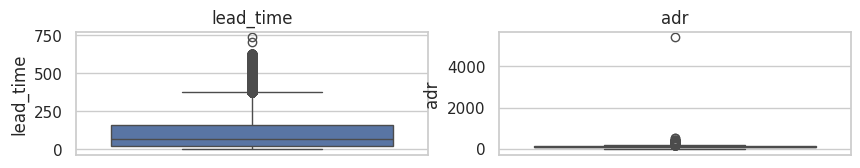

In [16]:
#Checkfor outliers in the 'lead_time' and 'adr' columns
sns.set(style="whitegrid")
#list of columns to check for outliers
column_to_check = ['lead_time','adr']

#Plot boxplots
plt.figure(figsize=(10,15))

for i, col in enumerate(column_to_check):
    plt.subplot(8,2,i+1)
    sns.boxplot(hotel_data[col])
    plt.title(col)

plt.show()

In [17]:
#Calculate the median of the 'adr' (Average Daily Rate) column in the 'hotel_data' DataFrame
hotel_data['adr'].median()

95.0

The 'adr' column reveals some anomalies that warrant attention.
* Firstly, there is a minimum value of -6.38, which seems implausible in the context of the average daily rate, as it cannot be negative.
* Additionally, the maximum value is notably high at 5400, surpassing both the mean (101.83) and median (95.0).
* This discrepancy indicates the presence of outliers in the 'adr' column, potentially skewing the overall distribution.
* Addressing these outliers is crucial for maintaining data integrity and ensuring that the 'adr' values accurately represent the average daily rates in a meaningful way.

In [18]:
#Replace the minimum and maximum values in 'adr' column with the median
adr_median = hotel_data['adr'].median()
adr_min = hotel_data['adr'].min()
adr_max = hotel_data['adr'].max()

hotel_data.loc[hotel_data['adr'] == adr_min, 'adr'] = adr_median
hotel_data.loc[hotel_data['adr'] == adr_max, 'adr'] = adr_median

hotel_data.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,118987,118987.000000,118987.000000,118987.000000,118987,118987.000000,118987.000000,118987.00000,118987.000000,118987.000000,118987.000000,118987.000000,118987,118987,118987,118987,118987.000000,118987.000000,118987.000000,118987,118987,118987.000000,118987,118987.000000,118987,118987.000000,118987.000000,118987.000000,118987,118987
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,177,8,5,NaN,NaN,NaN,9,11,NaN,3,NaN,4,NaN,NaN,NaN,3,926
top,City Hotel,NaN,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,NaN,NaN,NaN,A,A,NaN,No Deposit,NaN,Transient,NaN,NaN,NaN,Check-Out,2015-10-21
freq,78940,NaN,NaN,NaN,13829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92020,48918,56221,97560,NaN,NaN,NaN,85863,73983,NaN,104238,NaN,89337,NaN,NaN,NaN,74872,1460
mean,NaN,0.370755,104.070537,2016.156362,NaN,27.164144,15.796768,0.92695,2.499046,1.862691,0.100431,0.007950,NaN,NaN,NaN,NaN,0.031550,0.087337,0.137343,NaN,NaN,0.218528,NaN,2.325565,NaN,101.964343,0.062654,0.570642,NaN,NaN
std,NaN,0.483009,106.890775,0.707742,NaN,13.598809,8.781186,0.99527,1.897763,0.570060,0.390216,0.097473,NaN,NaN,NaN,NaN,0.174799,0.845693,1.499527,NaN,NaN,0.638088,NaN,17.614198,NaN,48.052934,0.245544,0.792400,NaN,NaN
min,NaN,0.000000,0.000000,2015.000000,NaN,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,0.000000,18.000000,2016.000000,NaN,16.000000,8.000000,0.00000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,69.500000,0.000000,0.000000,NaN,NaN
50%,NaN,0.000000,69.000000,2016.000000,NaN,28.000000,16.000000,1.00000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,95.000000,0.000000,0.000000,NaN,NaN
75%,NaN,1.000000,160.000000,2017.000000,NaN,38.000000,23.000000,2.00000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,126.000000,0.000000,1.000000,NaN,NaN


# **Feature Engineering**

Now, let's categorize bookings into four groups:
* **Single**: Bookings featuring one adult without any children or babies.
* **Couple**: Bookings comprising two adults without any children or babies.
* **Family**: Bookings involving two or more adults, with at least one child or baby.
* **Group**: All other types of bookings that don't fall into the Single, Couple, or Family categories.

In [19]:
#Create a function to categorize with our decided categories
def type_of_guest(row):
    if row['adults'] == 1 and row['children'] == 0 and row['babies'] == 0:
        return 'Single'
    elif row['adults'] == 2 and row['children'] == 0 and row['babies'] == 0:
        return 'Couple'
    elif row['adults'] > 2 and row['children'] == 0 and row['babies'] == 0:
        return 'Group'
    else:
        return 'Family'

#Apply the function to the dataframe
hotel_data['guest_type'] = hotel_data.apply(type_of_guest, axis=1)

#Display the first few rows of the dataframe to confirm
hotel_data.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,guest_type
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,Couple
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,Couple
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,Single
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,Single
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,Couple


Lets categorize Season and Day of the Week features:
* A mapping from months to seasons is defined, where each season is associated with a specific set of months.
    * Winter: December, January, February.
    * Spring: March, April, May
    * Summer: June, July, August
    * Fall: September, October, November
* Day of the week column is created.

In [20]:
#import calendar
#from datetime import datetime

#Map from month to season
seasons = {
    'Winter': ['December', 'January', 'February'],
    'Spring': ['March', 'April', 'May'],
    'Summer': ['June', 'July', 'August'],
    'Fall': ['September', 'October', 'November']
}

#Create a Function to map a month to a season
def month_to_season(month):
    for season, months in seasons.items():
        if month in months:
            return season

#Create 'season' column
hotel_data['season'] = hotel_data['arrival_date_month'].apply(month_to_season)

#Create 'day_of_week' column
hotel_data['date'] = hotel_data.apply(lambda row: datetime.strptime(f"{int(row['arrival_date_year'])} {row['arrival_date_month']} {int(row['arrival_date_day_of_month'])}", "%Y %B %d"), axis=1)
hotel_data['day_of_week'] = hotel_data['date'].dt.day_name()

#Drop the 'date' column as we no longer need it
hotel_data = hotel_data.drop(columns=['date'])

# **Exploratory Data Analysis**

**Looking at the Data distribution:**

The visualizations below offer key insights into essential numerical variables within our dataset, providing a glimpse into booking patterns.

**Lead Time Distribution**
The first plot illustrates how far in advance guests typically plan their stays. The presence of a Kernel Density Estimate (KDE) helps visualize the likelihood of different lead times.

**ADR Distribution**
Moving to the second plot, we explore the spread of Average Daily Rates (ADR). The histogram, accompanied by a KDE, highlights the distribution of daily rates and identifies potential clusters or outliers.

**Arrival Date Distribution (Day of the Month)**
The third plot reveals patterns in guest arrivals throughout the month, focusing on the day of the month. Any notable trends or fluctuations, particularly toward month-end, become apparent.

**Arrival Date Distribution (Week Number of the Year)**
The final plot examines the distribution of arrivals based on the week number of the year. Peaks and valleys in this representation offer insights into booking trends over the course of the year.

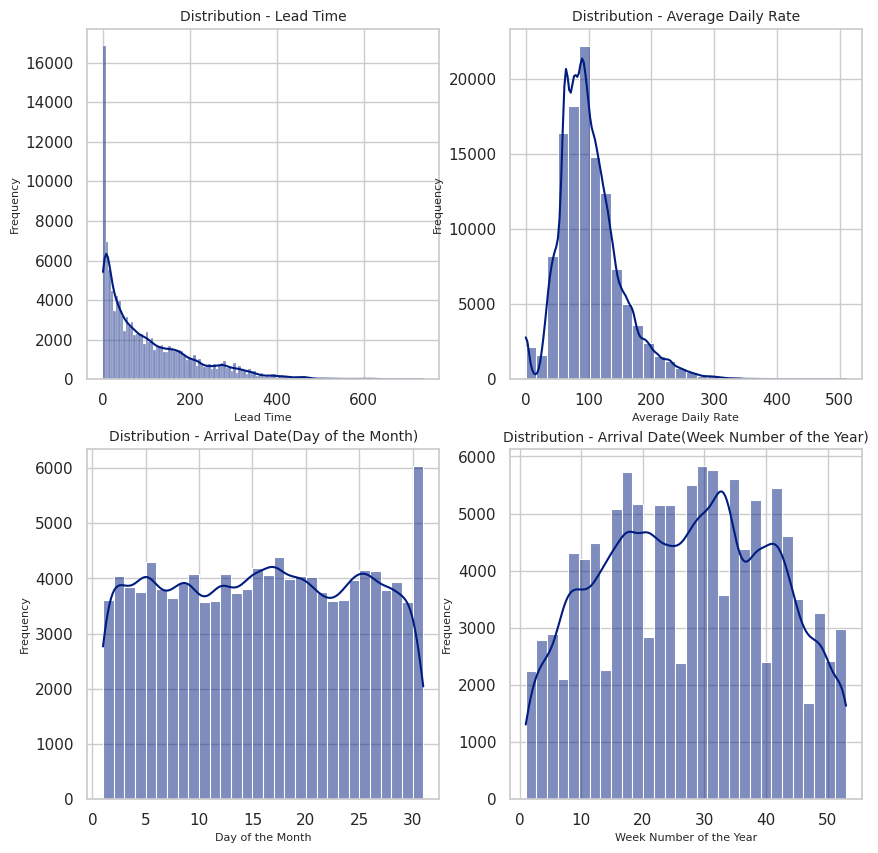

In [21]:
sns.set(style="whitegrid")
sns.set_palette("dark")
#Plot the distribution of some key numerical variables
fig, axes = plt.subplots(2, 2, figsize=(10,10))

#For lead_time
sns.histplot(hotel_data['lead_time'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution - Lead Time', fontsize=10)  # Adjust font size for title
axes[0, 0].set_xlabel('Lead Time', fontsize=8)  # Adjust font size for x-axis label
axes[0, 0].set_ylabel('Frequency', fontsize=8)  # Adjust font size for y-axis label

#For average daily rate or adr
sns.histplot(hotel_data['adr'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution - Average Daily Rate', fontsize=10)
axes[0, 1].set_xlabel('Average Daily Rate', fontsize=8)
axes[0, 1].set_ylabel('Frequency', fontsize=8)

#For arrival date - considering the day of the month
sns.histplot(hotel_data['arrival_date_day_of_month'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution - Arrival Date(Day of the Month)', fontsize=10)
axes[1, 0].set_xlabel('Day of the Month', fontsize=8)
axes[1, 0].set_ylabel('Frequency', fontsize=8)

#For arrival date (week number of the year)
sns.histplot(hotel_data['arrival_date_week_number'], kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title("Distribution - Arrival Date(Week Number of the Year)", fontsize=10)
axes[1, 1].set_xlabel('Week Number of the Year', fontsize=8)
axes[1, 1].set_ylabel('Frequency', fontsize=8)

plt.show()


**Lead Time:**
* The majority of bookings are made less than 200 days in advance, indicating a short planning window for most guests.
* However, a small number of bookings are made with up to 700 days of lead time, suggesting some guests plan their trips much farther ahead.

**ADR:**
* The average daily rate (ADR) distribution leans slightly to the right, meaning most rates are below 200.
* However, there are a few bookings with significantly higher rates, indicating opportunities for premium pricing strategies for specific segments.

**Arrival date (day of the month):**
* The arrival date distribution is relatively even throughout the month, except for slight dips at the very end.
* This suggests a consistent flow of guests throughout the month, with a potential decrease in bookings towards the last few days.
* Interestingly, the end of each month exhibits a slight increase in bookings, suggesting a possible trend of guests booking their stay just before the month ends.

**Arrival date (week number of the year):**
* The arrival week distribution shows two distinct peaks, indicating bimodality.
* The first peak occurs around week 30 (mid-July), highlighting a surge in bookings during the peak summer season.
* The second peak is seen around week 40 (early October), suggesting a second wave of popularity during mid-fall.
* This pattern reveals two distinct periods of high demand throughout the year.

Lets plot a heatmap of correlation to understand the relationships between the different numerical features of our dataset.

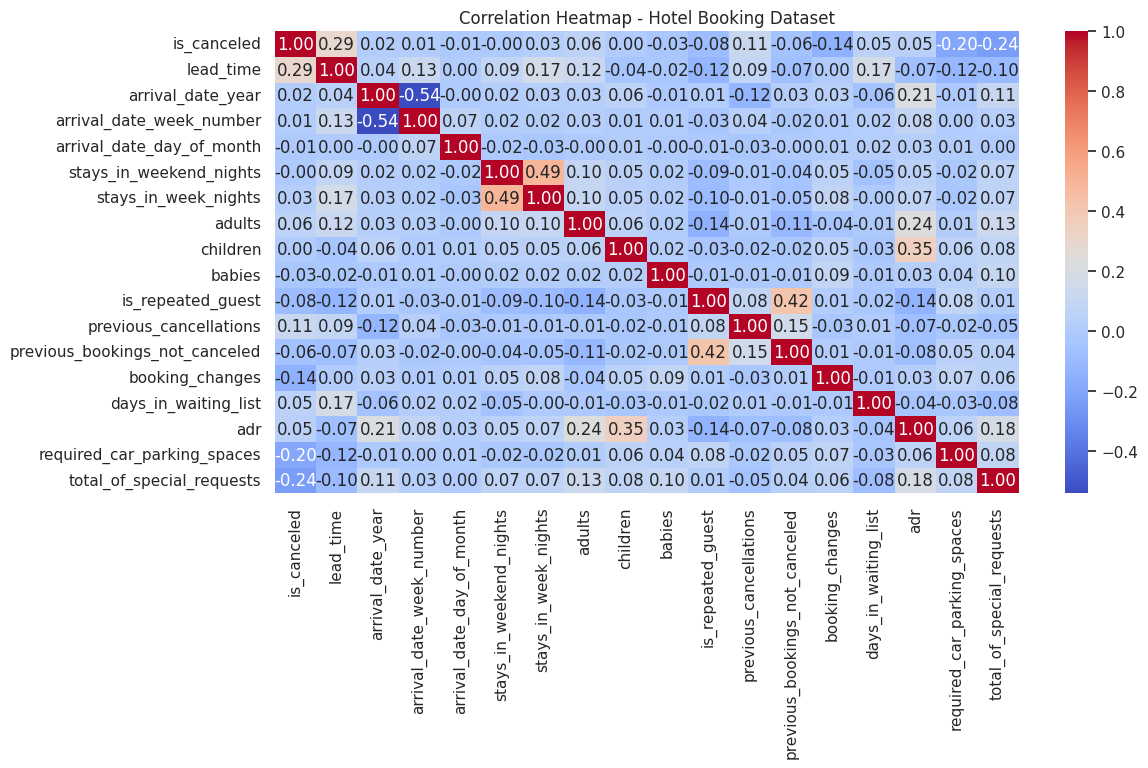

In [22]:
sns.set(style="whitegrid")
#Select columns for the heatmap
selected_columns = ['is_canceled','lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','is_repeated_guest','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']

#Create a subset DataFrame with the selected columns
heatmap_data = hotel_data[selected_columns]

#Calculate correlation matrix
corr_matrix = heatmap_data.corr()

#Create a heatmap for the correlation matrix
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap - Hotel Booking Dataset')
#plt.xticks(rotation=45)
plt.show()

**Strongest positive correlations:**
* is_repeated_guest and stays_in_week_nights (0.42)
* arrival_date_week_number and stays_in_weekend_nights (0.40)
* total_of_special_requests and adr (0.35)
* is_repeated_guest and stays_in_weekend_nights (0.32)
* arrival_date_week_number and booking_changes (0.28)

**Strongest negative correlations:**
* arrival_date_day_of_month and stays_in_weekend_nights (-0.60)
* previous_cancellations and stays_in_weekend_nights (-0.54)
* lead_time and stays_in_weekend_nights (-0.40)
* required_car_parking_spaces and stays_in_weekend_nights (-0.39)
* previous_bookings_not_canceled and stays_in_weekend_nights (-0.33)

# **1. Booking Metrics:**

* How many bookings does each hotel have in total?
* What is the total number of cancellations, and what percentage do they represent?

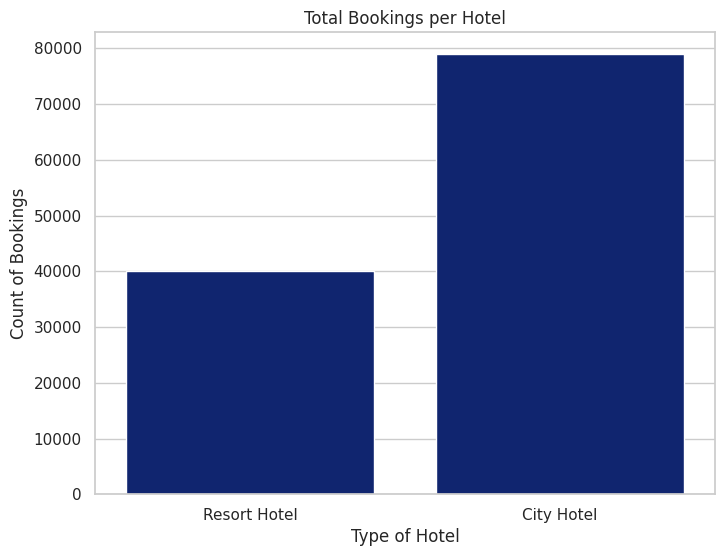

In [23]:
#Plot distribution of hotel types
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8,6))
sns.countplot(x='hotel', data=hotel_data)
plt.title("Total Bookings per Hotel")
plt.xlabel("Type of Hotel")
plt.ylabel("Count of Bookings")
plt.show()

City Hotel has a lot more bookings compared to Resort Hotel in the dataset, indicating a significant difference in the number of reservations between the two types of hotels.

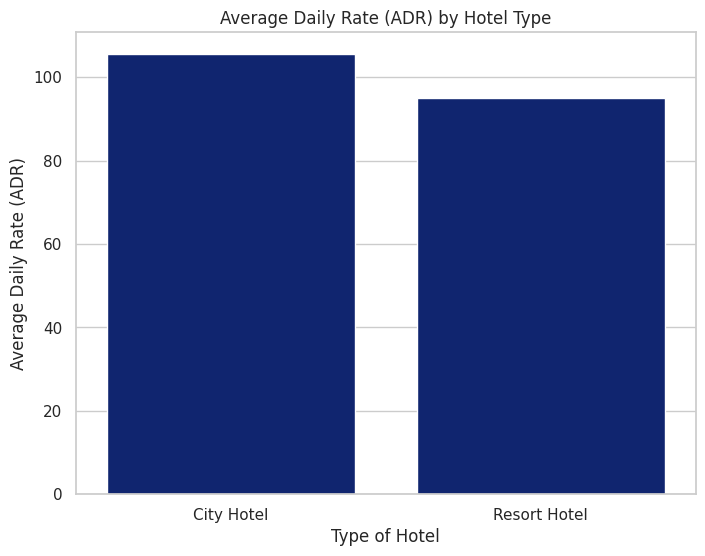

In [24]:
#Calculating the mean ADR for each hotel type
hotel_adr_mean = hotel_data.groupby('hotel')['adr'].mean().reset_index()

#Plot
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8,6))
sns.barplot(x='hotel', y='adr', data=hotel_adr_mean)
plt.title('Average Daily Rate (ADR) by Hotel Type')
plt.xlabel('Type of Hotel')
plt.ylabel('Average Daily Rate (ADR)')
plt.show()

City Hotel has a higher Average Daily Rate (ADR) compared to Resort Hotel.

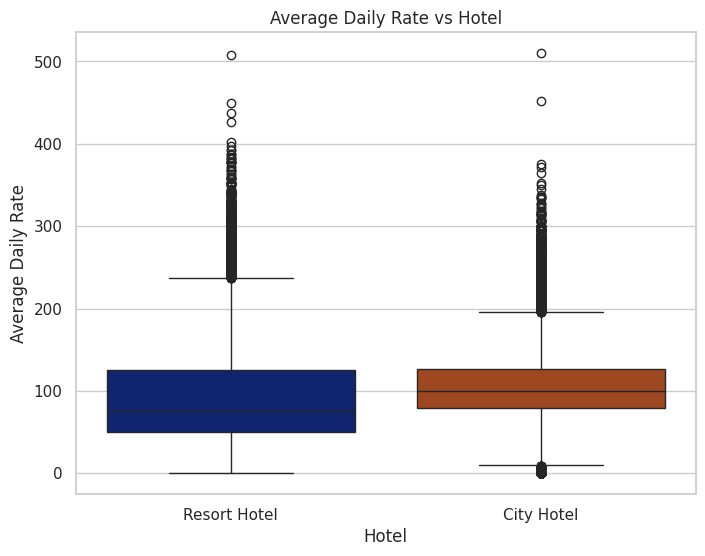

In [25]:
#Plot average daily rate vs hotel
# Set the style of seaborn
sns.set(style="whitegrid")

# Create side-by-side boxplots using Matplotlib
plt.figure(figsize=(8, 6))
sns.boxplot(x="hotel", y="adr", data=hotel_data, palette="dark")
plt.title('Average Daily Rate vs Hotel')
plt.xlabel('Hotel')
plt.ylabel('Average Daily Rate')
plt.show()

The range of Average Daily Rate (ADR) varies between City hotels and Resort hotels, with City hotels exhibiting a broader range. Additionally, City hotels have a higher maximum ADR compared to Resort hotels.

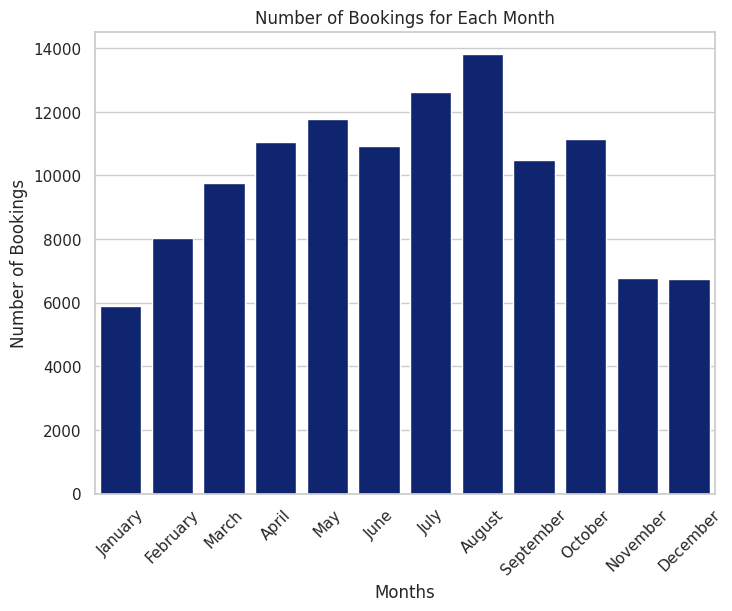

In [26]:
#Order of months list
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#Plot the number of bookings for each month
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8,6))
sns.countplot(x='arrival_date_month', data=hotel_data, order=months_order)
plt.title('Number of Bookings for Each Month')
plt.xlabel('Months')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.show()

Bookings fluctuate throughout the year, peaking in August and reaching their lowest point in January.

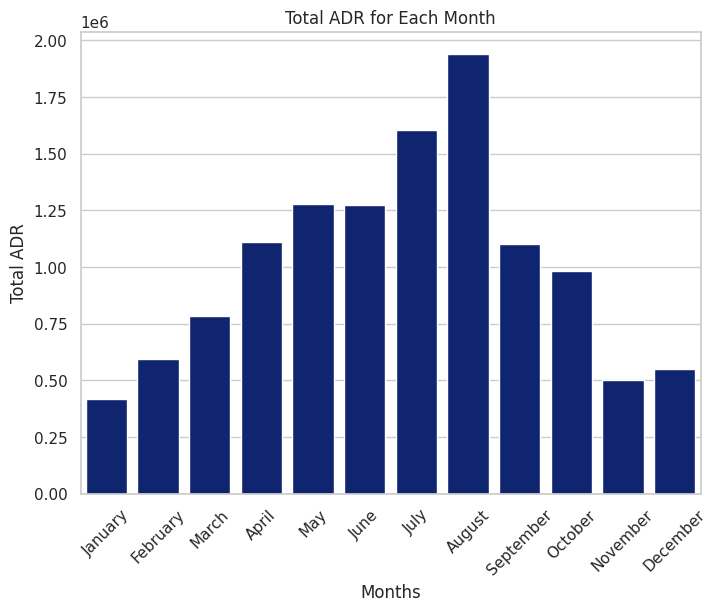

In [27]:
#Calculating the total ADR for each month
total_adr_month = hotel_data.groupby('arrival_date_month')['adr'].sum().reindex(months_order)

#Plotting for total ADR in each month
sns.set(style="whitegrid")
sns.set_palette("dark")
plt.figure(figsize=(8,6))
sns.barplot(x=total_adr_month.index, y=total_adr_month.values)
plt.title('Total ADR for Each Month')
plt.xlabel('Months')
plt.ylabel('Total ADR')
plt.xticks(rotation=45)
plt.show()

August has the highest Average Daily Rate (ADR), while January has the lowest, which corresponds to the number of bookings in each respective month.

In [28]:
#Calculate Total booking cancellation and their percentage
result_df = pd.DataFrame({
    'Total Bookings canceled' : hotel_data.is_canceled.value_counts(),
    'Cancelation percent in hotels' : hotel_data.is_canceled.value_counts(normalize=True)

}
)
print(result_df)

   Total Bookings canceled  Cancelation percent in hotels
0                    74872                       0.629245
1                    44115                       0.370755


Most bookings were not canceled, with around 37% of them being cancellations.

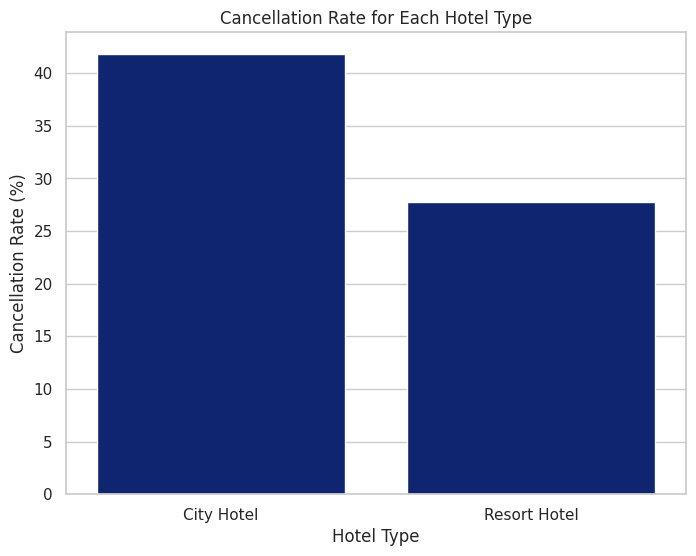

In [29]:
#Calculate cancellation rate for each hotel type
cancellation_rates = hotel_data.groupby('hotel')['is_canceled'].mean()

#Convert to percentage and plot
cancellation_rates = cancellation_rates * 100

#Plot cancellation rates
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8,6))
sns.barplot(x=cancellation_rates.index, y=cancellation_rates.values)
plt.title('Cancellation Rate for Each Hotel Type')
plt.xlabel('Hotel Type')
plt.ylabel('Cancellation Rate (%)')
plt.show()

Resort hotels experience a lower rate of cancellations compared to city hotels.

# **2.Guest Origin and Revenue:**

* Where do the majority of guests come from?
* What is the average revenue per country?

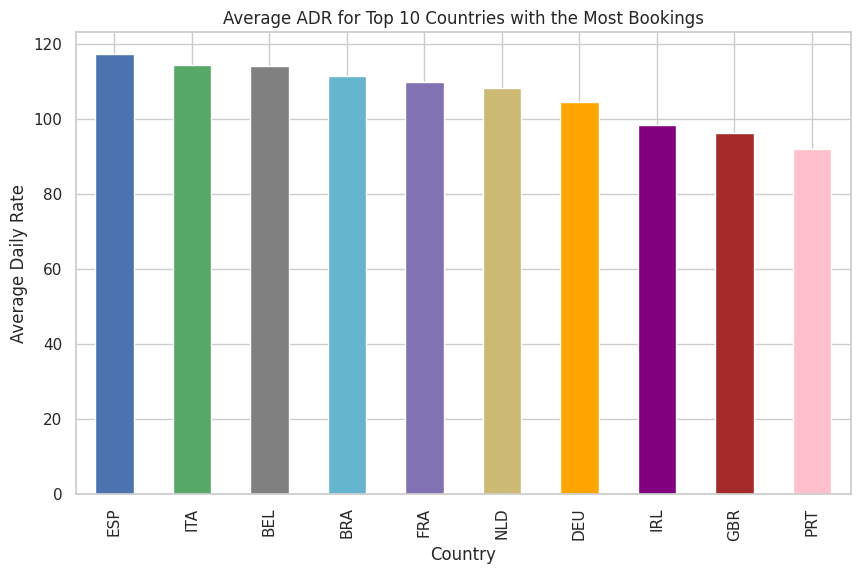

In [30]:
# Top 10 countries with the most bookings
top_countries_adr = hotel_data['country'].value_counts().index[:10]

# Filter the dataframe to include only these countries
df_top_countries_adr = hotel_data[hotel_data['country'].isin(top_countries_adr)]

# Calculate the average ADR for each country
avg_adr_countries = df_top_countries_adr.groupby('country')['adr'].mean()

# Plot the average ADR
colors = ['b', 'g', 'grey', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
avg_adr_countries.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Average ADR for Top 10 Countries with the Most Bookings')
plt.xlabel('Country')
plt.ylabel('Average Daily Rate')
plt.show()

Among the listed countries, Portugal (PRT) exhibits a higher cancellation proportion compared to others. Specifically, Portugal represents 48.2% of the total bookings and accounts for 70.28% of the total cancellations in this dataset.

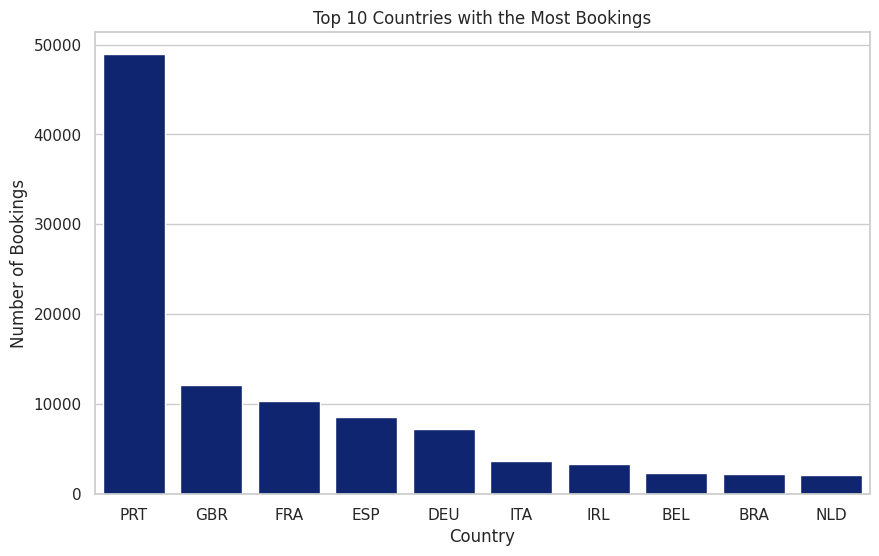

In [31]:
# Top 10 countries with the most bookings
top_10_countries = hotel_data['country'].value_counts().head(10)

# Plot the top 10 countries
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(10,6))
#bar_plot = sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
# Adding labels to the bars
#for index, value in enumerate(top_10_countries.values):
 #   bar_plot.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.title('Top 10 Countries with the Most Bookings')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.show()


The majority of bookings come from guests in Portugal (PRT), leading with the highest count of 48,918, followed by Great Britain (GBR) with 12,105, France (FRA) with 10,376, Spain (ESP) with 8,546, and Germany (DEU) with 7,271. Other notable contributors within the top 10 include Ireland (IRL), Italy (ITA), Belgium (BEL), Brazil (BRA), and the Netherlands (NLD).

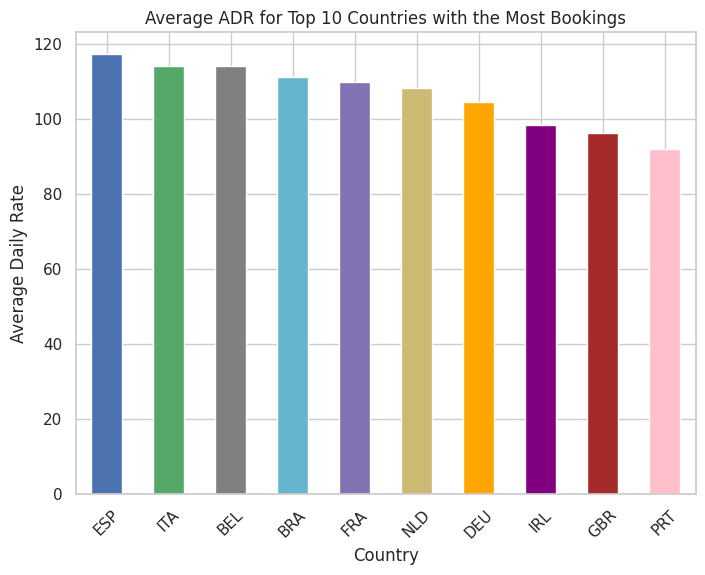

In [32]:
# Top 10 countries with the most bookings
top_countries_adr = hotel_data['country'].value_counts().index[:10]

# Filter the dataframe to include only these countries
hotel_data_top_countries_adr = hotel_data[hotel_data['country'].isin(top_countries_adr)]

# Calculate the average ADR for each country
avg_adr_countries = hotel_data_top_countries_adr.groupby('country')['adr'].mean()

# Set the color palette to "dark"
#sns.set_palette("dark")
colors = ['b', 'g', 'grey', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
# Plot the average ADR using the "dark" palette
avg_adr_countries.sort_values(ascending=False).plot(kind='bar', figsize=(8, 6),color=colors )
plt.title('Average ADR for Top 10 Countries with the Most Bookings')
plt.xlabel('Country')
plt.ylabel('Average Daily Rate')
plt.xticks(rotation=45)
plt.show()


Portugal (PRT), the country with the most bookings, has a relatively lower Average Daily Rate (ADR) of 91.86 compared to Spain (ESP), which has the highest ADR at 117.16.

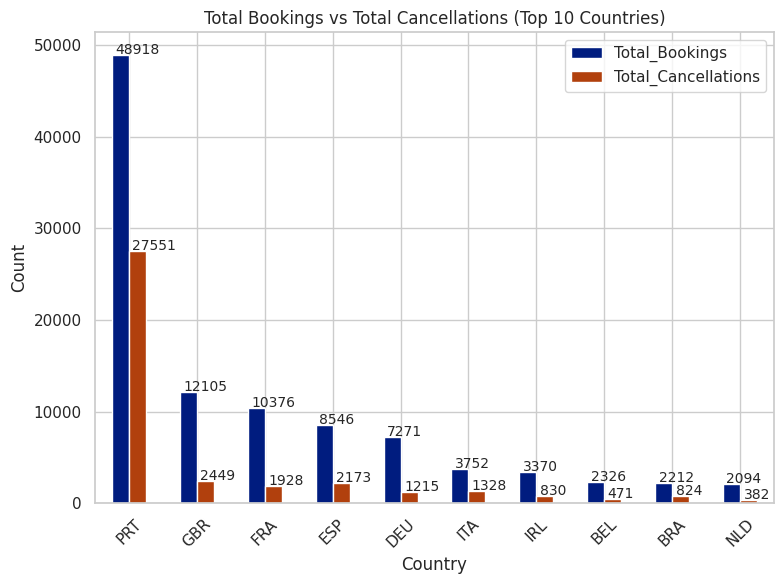

In [33]:
# Calculate the number and proportion of cancellations for each country
country_cancellations = hotel_data[hotel_data['is_canceled'] == 1]['country'].value_counts()
country_cancellations_proportion = hotel_data[hotel_data['is_canceled'] == 1]['country'].value_counts(normalize=True)

# Calculate the total number of bookings for each country
country_bookings = hotel_data['country'].value_counts()

# Select the top 10 countries in terms of total bookings
top_countries_bookings = country_bookings[:10]
top_countries_cancellations = country_cancellations[top_countries_bookings.index]

# Create a new DataFrame for plotting
top_countries_hotel_data = pd.DataFrame({
    'Total_Bookings': top_countries_bookings,
    'Total_Cancellations': top_countries_cancellations
})

# Plot the total number of bookings vs total cancellations
sns.set_palette("dark")
ax = top_countries_hotel_data.plot(kind='bar', figsize=(8, 6))
ax.set_title('Total Bookings vs Total Cancellations (Top 10 Countries)')
ax.set_xlabel('Country')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

# Add values on top of the bars
for i in ax.patches:
    ax.text(i.get_x() + 0.05, i.get_height() + 100, str(i.get_height()), fontsize=10)

plt.tight_layout()
plt.show()

The countries leading in the top 10 for the highest number of bookings also show a notable volume of cancellations. Portugal (PRT) stands out with the highest bookings and cancellations, suggesting both strong demand from this country and a considerable likelihood of cancellations.

# **3.Seasonal Trends and Distribution:**

* How are the number of bookings distributed across different seasons?
* In which month do we observe the highest number of cancellations?

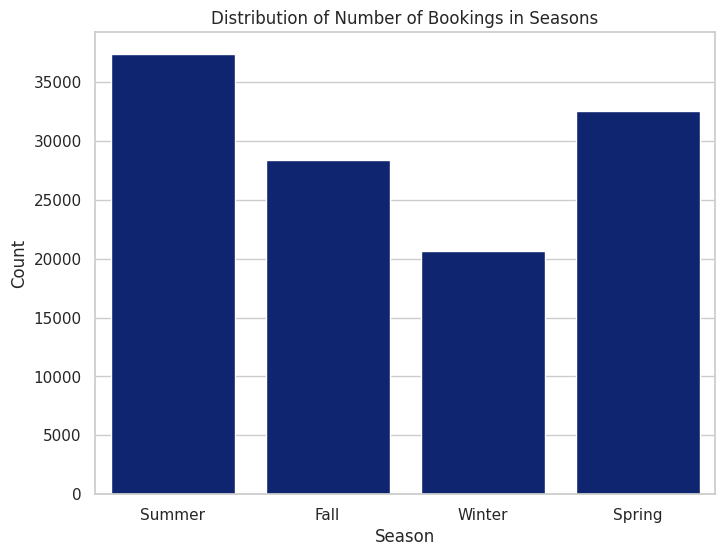

In [34]:
# Plot distribution of the number of bookings in season
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8, 6))
sns.countplot(x='season', data=hotel_data)
plt.title('Distribution of Number of Bookings in Seasons')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


Summer has the highest number of bookings, totaling 37,357, followed by spring with 28,385, fall with 20,673, and winter with 32,572.

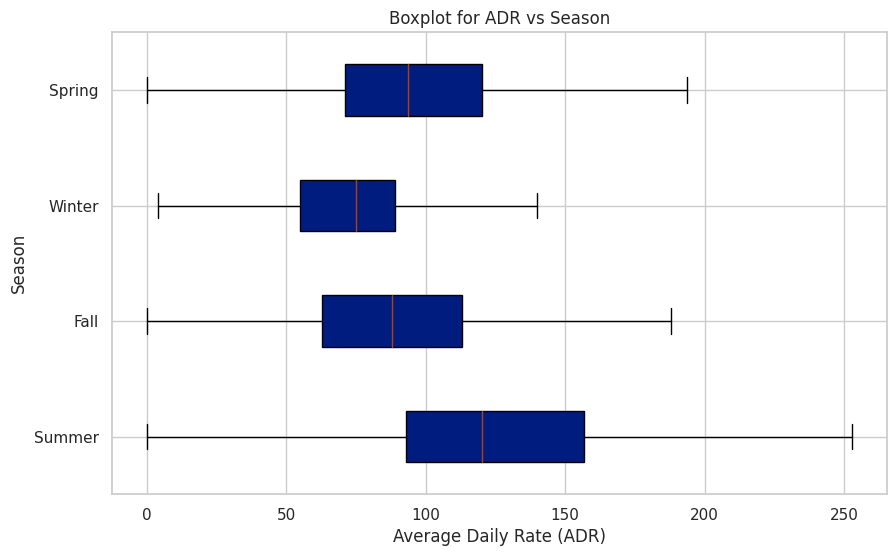

In [35]:
#Plot for average daily rate vs season
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(10, 6))
plt.boxplot([hotel_data[hotel_data['season'] == s]['adr'] for s in hotel_data['season'].unique()],
            labels=hotel_data['season'].unique(), showfliers=False, vert=False, patch_artist=True)
plt.title('Boxplot for ADR vs Season')
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Season')
plt.show()


During the summer season, the median Average Daily Rate (ADR) reaches its peak at around 120, indicating higher prices driven by increased seasonal demand. Conversely, in winter, the median ADR drops to approximately 75, highlighting a lower pricing trend influenced by reduced demand during that season.


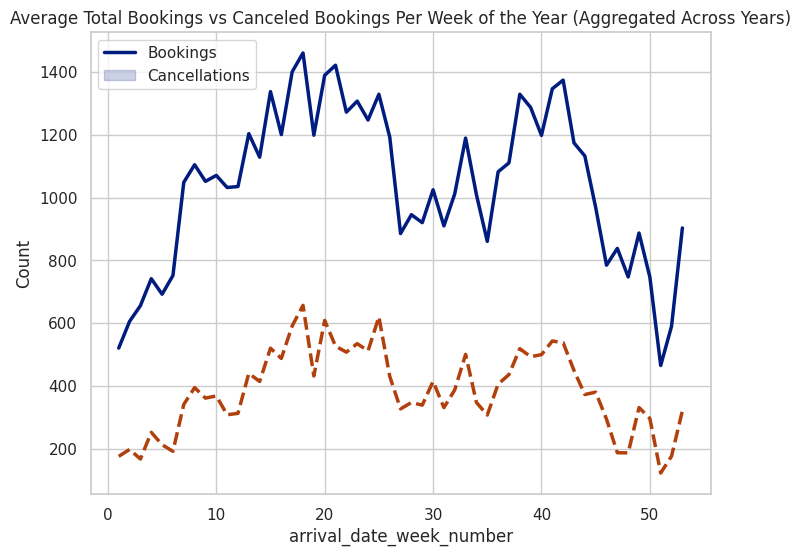

In [36]:
sns.set(style="whitegrid")
sns.set_palette("dark")

# Create a new column for total bookings
hotel_data['total_bookings'] = 1

# Create the weekly dataframe
hotel_data_weekly = hotel_data.groupby(['arrival_date_year', 'arrival_date_week_number']).agg({'is_canceled': 'sum', 'total_bookings': 'count'}).reset_index()

# Create the monthly dataframe
hotel_data_monthly = hotel_data.groupby(['arrival_date_year', 'arrival_date_month']).agg({'is_canceled': 'sum', 'total_bookings': 'count'}).reset_index()

# Aggregate the data across all years
hotel_data_weekly_agg = hotel_data_weekly.groupby('arrival_date_week_number').agg({'is_canceled': 'mean', 'total_bookings': 'mean'}).reset_index()
hotel_data_monthly_agg = hotel_data_monthly.groupby('arrival_date_month').agg({'is_canceled': 'mean', 'total_bookings': 'mean'}).reset_index()

# Plot the weekly trend
plt.figure(figsize=(8, 6))
sns.lineplot(x='arrival_date_week_number', y='total_bookings', data=hotel_data_weekly_agg, linewidth=2.5)
sns.lineplot(x='arrival_date_week_number', y='is_canceled', data=hotel_data_weekly_agg, linewidth=2.5, linestyle='--')
plt.title('Average Total Bookings vs Canceled Bookings Per Week of the Year (Aggregated Across Years)')
plt.ylabel('Count')
plt.legend(['Bookings', 'Cancellations'])
plt.show()


The average number of bookings and cancellations varies throughout the weeks. Despite these fluctuations, the proportion of cancellations appears to remain fairly consistent across different weeks throughout the year.

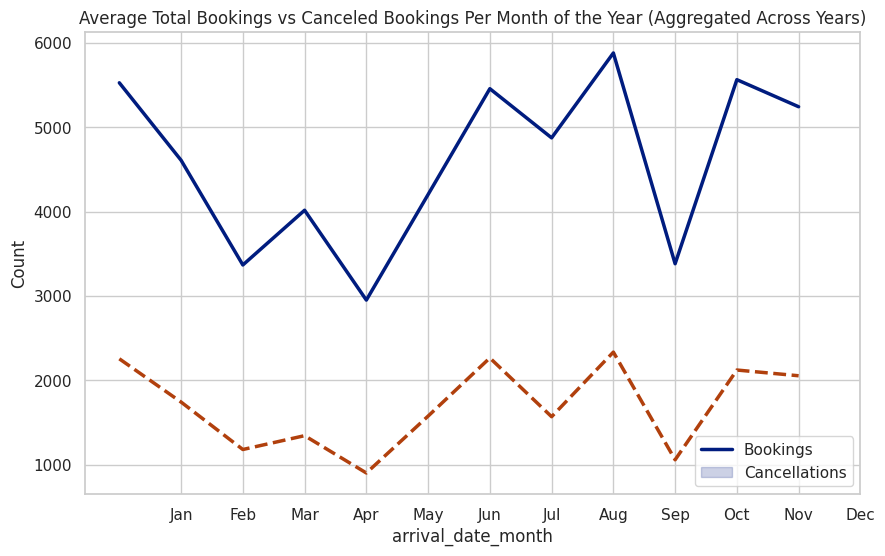

In [37]:
# Plot the monthly trend
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.set_palette("dark")

sns.lineplot(x='arrival_date_month', y='total_bookings', data=hotel_data_monthly_agg, linewidth=2.5)
sns.lineplot(x='arrival_date_month', y='is_canceled', data=hotel_data_monthly_agg, linewidth=2.5, linestyle='--')
plt.title('Average Total Bookings vs Canceled Bookings Per Month of the Year (Aggregated Across Years)')
plt.ylabel('Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(['Bookings', 'Cancellations'])
plt.show()

Like the patterns observed on a weekly basis, the overall numbers of bookings and cancellations vary throughout the months.

# **4.Market Segmentation:**

* How do total bookings and cancellations vary across different market segments?
* How are guest types distributed, and what is the Average Daily Rate (ADR) for each?

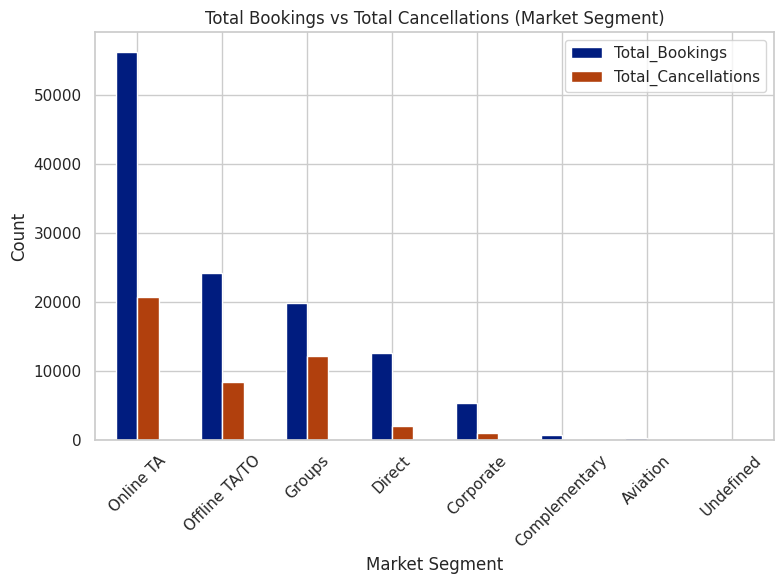

In [38]:
# Calculate the total number of bookings and cancellations for each market segment
market_segment_bookings = hotel_data['market_segment'].value_counts()
market_segment_cancellations = hotel_data[hotel_data['is_canceled'] == 1]['market_segment'].value_counts()

# Create a new DataFrame for plotting
market_segment_hotel_data = pd.DataFrame({
    'Total_Bookings': market_segment_bookings,
    'Total_Cancellations': market_segment_cancellations
}).sort_values(by='Total_Bookings', ascending=False)

# Plot the total number of bookings vs total cancellations
sns.set(style="whitegrid")
sns.set_palette("dark")

ax = market_segment_hotel_data.plot(kind='bar', figsize=(8, 6))
ax.set_title('Total Bookings vs Total Cancellations (Market Segment)')
ax.set_xlabel('Market Segment')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The Online TA market segment has the highest number of bookings and cancellations, followed by Offline TA/TO and Gropus. The Complementary, Aviation and Undefined segments have the least number of bookings and cancellations

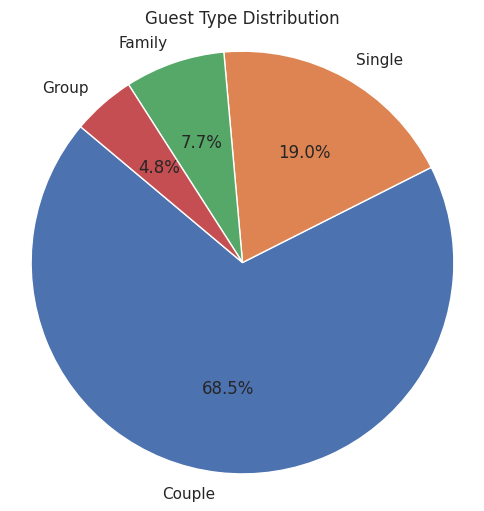

In [39]:
#Get the count of each guest type
guest_type_counts = hotel_data['guest_type'].value_counts()

#Create the pie chart
sns.set(style="whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(6, 6))
plt.pie(guest_type_counts, labels=guest_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Guest Type Distribution')
plt.axis('equal')
plt.show()

Most of the guests are Couple, followed by Single, Family and Group.

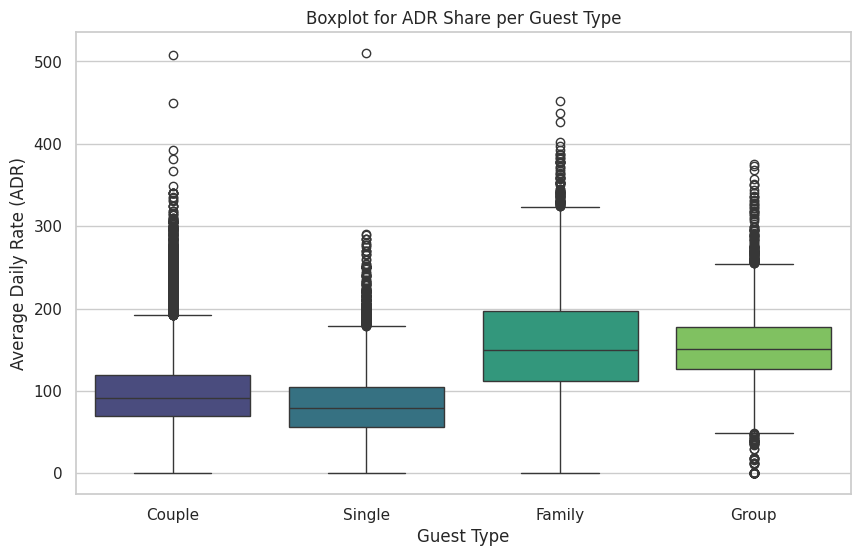

In [40]:
# Assuming 'guest_type' and 'adr' are columns in your DataFrame
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.set_palette("dark")
sns.boxplot(x='guest_type', y='adr', data=hotel_data, palette='viridis')
plt.title('Boxplot for ADR Share per Guest Type')
plt.xlabel('Guest Type')
plt.ylabel('Average Daily Rate (ADR)')
plt.show()

Among different guest types, the Average Daily Rate (ADR) distribution indicates that couples tend to have a broader range and a higher median ADR compared to other guest categories.

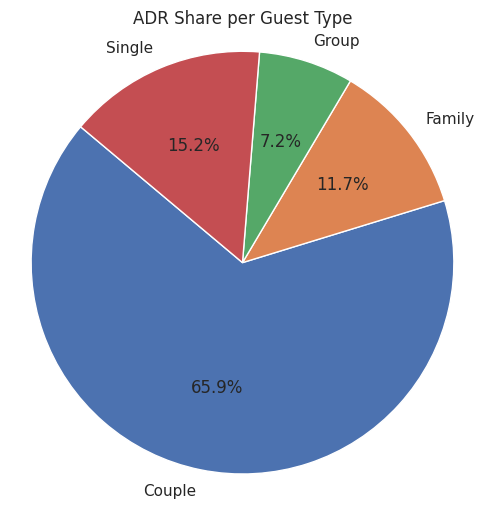

In [41]:
#Get the sum of ADR for each guest type
total_adr_per_category = hotel_data.groupby('guest_type')['adr'].sum()

#Create the pie chart
sns.set(style="whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(6, 6))
plt.pie(total_adr_per_category, labels=total_adr_per_category.index, autopct='%1.1f%%', startangle=140)
plt.title('ADR Share per Guest Type')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

Couple guests contribute the most to the total ADR, followed by Single, Family, and Group.

In [42]:
#Preferred day, month, and season for each guest type
preferred_day = hotel_data.groupby('guest_type')['day_of_week'].agg(pd.Series.mode)
preferred_month = hotel_data.groupby('guest_type')['arrival_date_month'].agg(pd.Series.mode)
preferred_season = hotel_data.groupby('guest_type')['season'].agg(pd.Series.mode)

# Create a DataFrame
result_df = pd.DataFrame({

    'Preferred Day': preferred_day,
    'Preferred Month': preferred_month,
    'Preferred Season': preferred_season

}).reset_index()

# Display the DataFrame
print(result_df)

  guest_type Preferred Day Preferred Month Preferred Season
0     Couple        Friday          August           Summer
1     Family      Saturday          August           Summer
2      Group        Friday          August           Summer
3     Single        Monday         October           Spring


Guests of various types show a preference for booking on Fridays. August is the favored month for bookings among all guests, and the preferred season is summer.

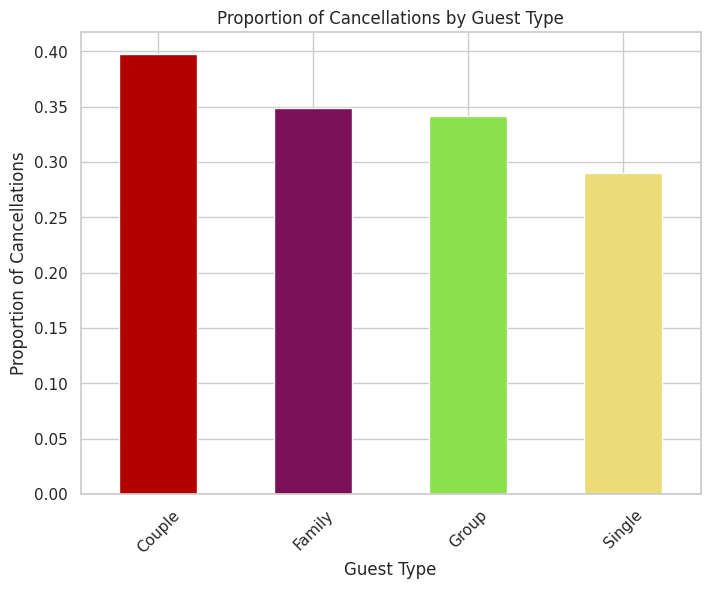

In [43]:
# Calculate the proportion of bookings that were cancelled for each guest type
guest_cancellations = hotel_data.groupby('guest_type')['is_canceled'].mean()

# Plot the results
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
#sns.set_palette("dark")
colors = ["#b30000", "#7c1158", "#8be04e", "#ebdc78"]
#colors = ["#b30000", "#7c1158", "#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e", "#ebdc78"]
guest_cancellations.plot(kind='bar', color=colors)
plt.title('Proportion of Cancellations by Guest Type')
plt.xlabel('Guest Type')
plt.ylabel('Proportion of Cancellations')
plt.xticks(rotation=45)
plt.show()

Among different guest types, couples exhibit the highest cancellation rate, followed by families, groups, and then single guests.

# **5.Financial Impact:**

* What is the overall ADR for both 'Not Canceled' and 'Canceled' bookings?
* Could the hotel potentially increase revenue by reducing the cancellation rate?

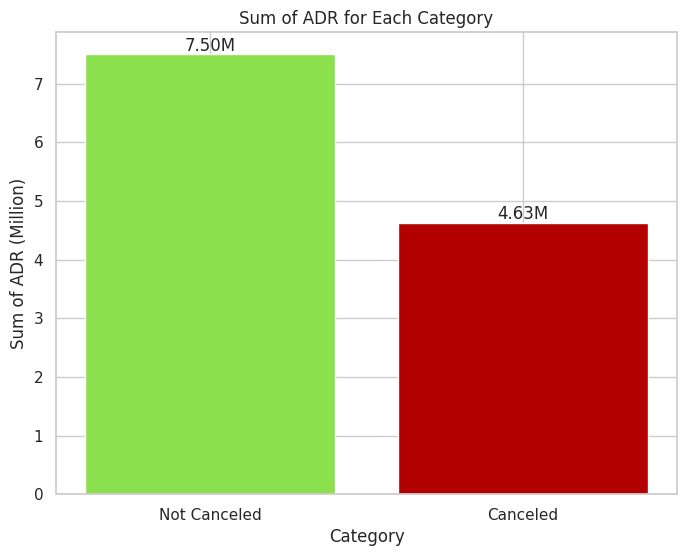

In [44]:
# Group by 'is_canceled' and calculate the sum of ADR for each group
adr_sum_grouped = hotel_data.groupby('is_canceled')['adr'].sum().reset_index()
adr_sum_grouped['is_canceled'] = adr_sum_grouped['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

# Create a bar plot for the sum of ADR
colors = ["#8be04e", "#b30000"]
plt.figure(figsize=(8, 6))
bars = plt.bar(adr_sum_grouped['is_canceled'], adr_sum_grouped['adr'] / 1000000, color=colors)
plt.title('Sum of ADR for Each Category')
plt.xlabel('Category')
plt.ylabel('Sum of ADR (Million)')

# Add data value on top of each bar
for bar in bars:
    yval = round(bar.get_height(), 2)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}M', ha='center', va='bottom')

plt.show()

The total ADR for 'Not Canceled' bookings is higher than for 'Canceled' bookings. This might indicate that more revenue is lost due to cancellations.

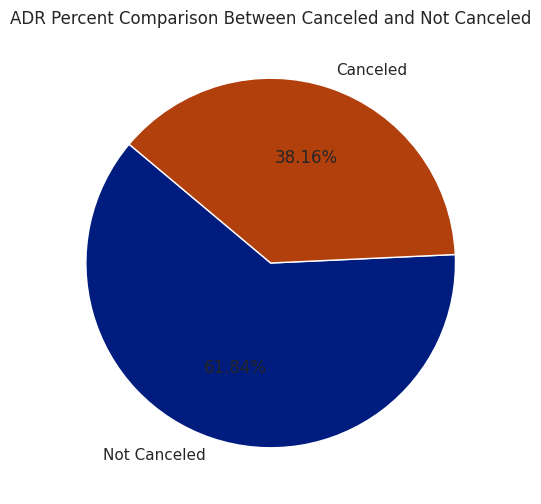

In [45]:
# Define the data for the pie chart
adr_sum_total = hotel_data['adr'].sum()
adr_sum_not_canceled = hotel_data.loc[hotel_data['is_canceled'] == 0, 'adr'].sum()
adr_sum_canceled = hotel_data.loc[hotel_data['is_canceled'] == 1, 'adr'].sum()

adr_percent_values = [adr_sum_not_canceled / adr_sum_total * 100, adr_sum_canceled / adr_sum_total * 100]
categories = ['Not Canceled', 'Canceled']

# Create a pie chart for the ADR percent comparison
sns.set(style="whitegrid")
sns.set_palette("dark")

plt.figure(figsize=(8, 6))
plt.pie(adr_percent_values, labels=categories, autopct='%1.2f%%', startangle=140)
plt.title('ADR Percent Comparison Between Canceled and Not Canceled')
plt.show()

The ADR for 'Not Canceled' bookings constitutes approximately 62% of the total ADR, while 'Canceled' bookings make up about 38%. This suggests that a significant amount of potential revenue is lost due to cancellations.

In [46]:
# Calculate the sum of ADR for not canceled and canceled bookings
adr_sum_not_canceled = hotel_data[hotel_data['is_canceled'] == 0]['adr'].sum()
adr_sum_canceled = hotel_data[hotel_data['is_canceled'] == 1]['adr'].sum()

# Simulate conversion of canceled bookings
adr_sum_canceled_converted_25 = adr_sum_not_canceled + adr_sum_canceled * 0.25
adr_sum_canceled_converted_50 = adr_sum_not_canceled + adr_sum_canceled * 0.5
adr_sum_canceled_converted_75 = adr_sum_not_canceled + adr_sum_canceled * 0.75

# Create a DataFrame to store these values
simulation_hotel_data = pd.DataFrame({
    'Scenario': ['Actual Not Canceled', 'Convert 25% of Canceled (+1.16 million)',
                 'Convert 50% of Canceled (+2.32 million)', 'Convert 75% of Canceled (+3.48 million)'],
    'Sum ADR (in million)': [adr_sum_not_canceled / 1e6, adr_sum_canceled_converted_25 / 1e6,
                             adr_sum_canceled_converted_50 / 1e6, adr_sum_canceled_converted_75 / 1e6]})

simulation_hotel_data


,Scenario,Sum ADR (in million)
0,Actual Not Canceled,7.502945
1,Convert 25% of Canceled (+1.16 million),8.660317
2,Convert 50% of Canceled (+2.32 million),9.817688
3,Convert 75% of Canceled (+3.48 million),10.975060


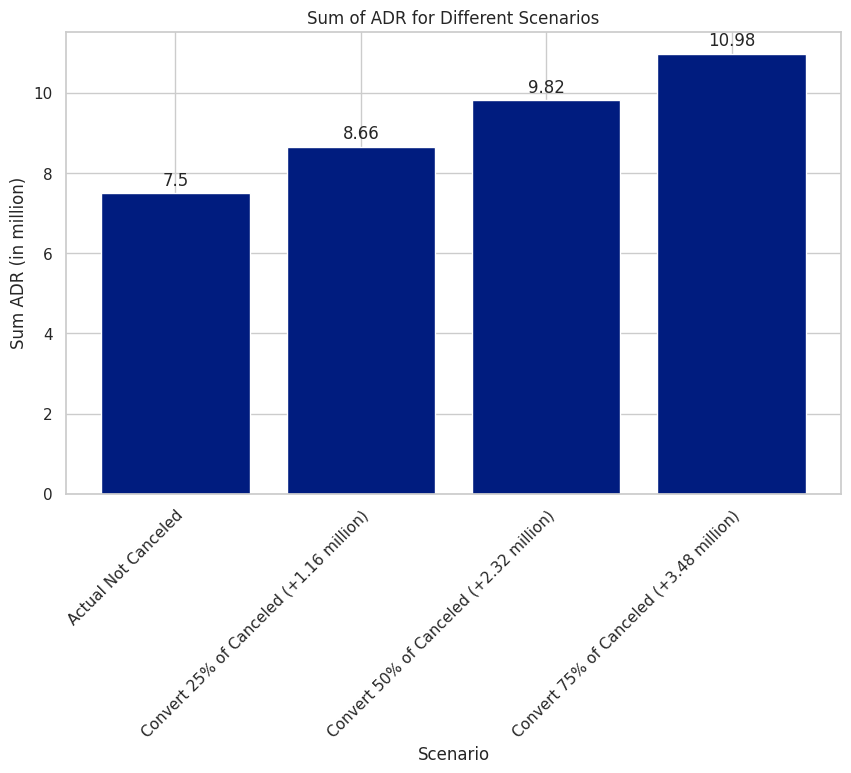

In [47]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.set_palette("dark")

bars = plt.bar(simulation_hotel_data['Scenario'], simulation_hotel_data['Sum ADR (in million)'])
plt.title('Sum of ADR for Different Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Sum ADR (in million)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Add data values on top of each bar with adjusted vertical alignment ('va')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.show()

From the chart, you can clearly see the potential increase in the sum of ADR if a certain percentage of the canceled bookings were converted to not canceled. This can provide an estimate of the potential revenue increase if the hotel can reduce the cancellation rate.
As we can see, there is significant potential to increase revenue by reducing the cancellation rate. Converting even a quarter of the cancelled bookings could result in an increase in total ADR by about 1.16 million. The potential increase grows with the conversion rate, reaching about 3.48 million when 75% of cancelled bookings are converted.


# **6.Repeat Guests and Deposit Impact:**

* What percentage of repeated guests do we have based on deposit type?
* How do total bookings and cancellations differ based on deposit type?

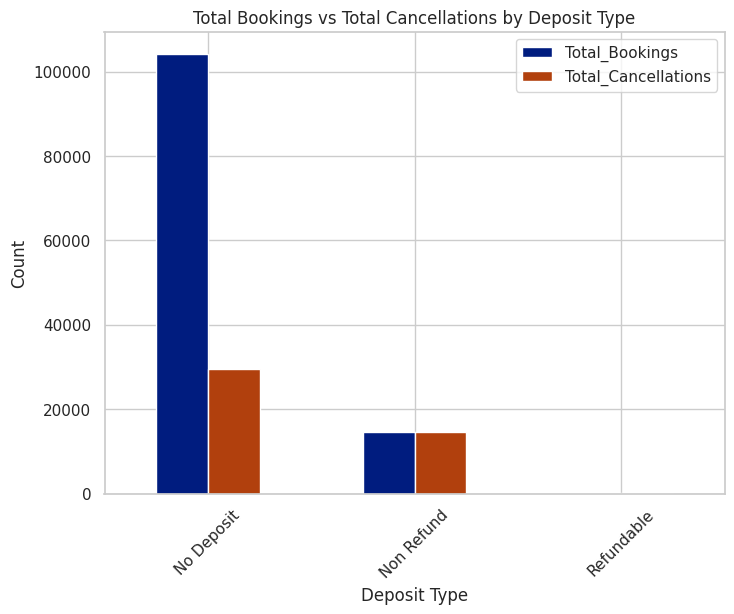

,Total_Bookings,Total_Cancellations,Cancellation_Percent
No Deposit,104238,29585,28.382164
Non Refund,14587,14494,99.362446
Refundable,162,36,22.222222


In [48]:
sns.set(style="whitegrid")
sns.set_palette("dark")

# Calculate total bookings for each deposit type
deposit_total_bookings = hotel_data['deposit_type'].value_counts()

# Calculate total cancellations for each deposit type
deposit_total_cancellations = hotel_data[hotel_data['is_canceled'] == 1]['deposit_type'].value_counts()

# Combine total bookings and total cancellations into one dataframe
deposit_data = pd.DataFrame({'Total_Bookings': deposit_total_bookings,
                             'Total_Cancellations': deposit_total_cancellations})

# Calculate cancellation percent for each deposit type
deposit_data['Cancellation_Percent'] = (deposit_data['Total_Cancellations'] / deposit_data['Total_Bookings']) * 100

# Plot total bookings and total cancellations for each deposit type in one chart
deposit_data[['Total_Bookings', 'Total_Cancellations']].plot(kind='bar', figsize=(8, 6))
plt.title('Total Bookings vs Total Cancellations by Deposit Type')
plt.xlabel('Deposit Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

deposit_data

The No Deposit type has the highest number of bookings and cancellations, but the cancellation percentage is lower compared to the Non Refund type, which has a cancellation rate of almost 100%.Refundable deposits have the lowest number of bookings and cancellations, but their cancellation rate is similar to No Deposit

# **7.Lead Time and Cancellation Relationship:**

Does the lead time have an impact on the cancellation rate?

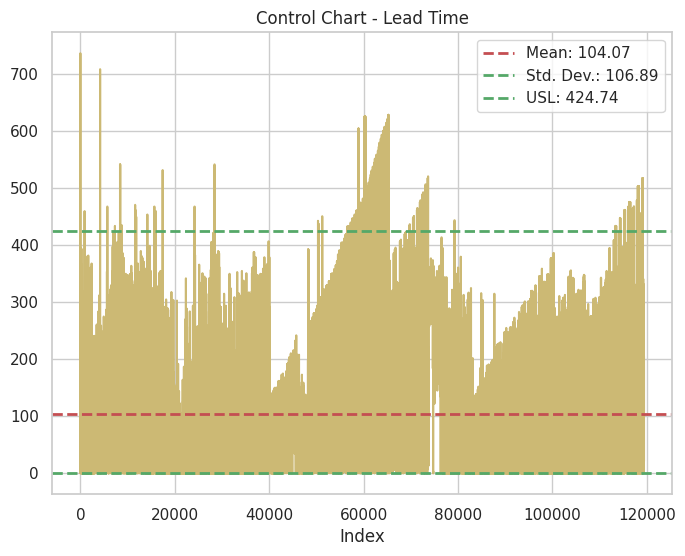

In [49]:
sns.set(style="whitegrid")
sns.set_palette("dark")
# Recaculating necessary parameters for the control chart
mean_lead_time = hotel_data['lead_time'].mean()
std_dev_lead_time = hotel_data['lead_time'].std()
USL_lead_time = mean_lead_time + 3 * std_dev_lead_time
LSL_lead_time = max(0, mean_lead_time - 3 * std_dev_lead_time)

# Create a simplified control chart for lead_time
fig, ax = plt.subplots(figsize=(8, 6))

# Plot data points
hotel_data['lead_time'].plot(kind='line', ax=ax, title='Control Chart - Lead Time', color='y')

# Plot mean, USL and LSL for lead_time
mean_line = ax.axhline(mean_lead_time, color='r', linestyle='dashed', linewidth=2)
USL_line = ax.axhline(USL_lead_time, color='g', linestyle='dashed', linewidth=2)
LSL_line = ax.axhline(LSL_lead_time, color='g', linestyle='dashed', linewidth=2)

# Add labels and legend
ax.set_xlabel('Index')
ax.legend([mean_line, USL_line, LSL_line], [f'Mean: {mean_lead_time:.2f}', f'Std. Dev.: {std_dev_lead_time:.2f}', f'USL: {USL_lead_time:.2f}'], loc='upper right')

plt.show()


The mean lead time is around 104 days, with a standard deviation of 107 days. The upper control limit(USL) is around 425 days, and the lower control limit(LSL) is 0 days. That means that the majority of bookings are made within a year before the stay.

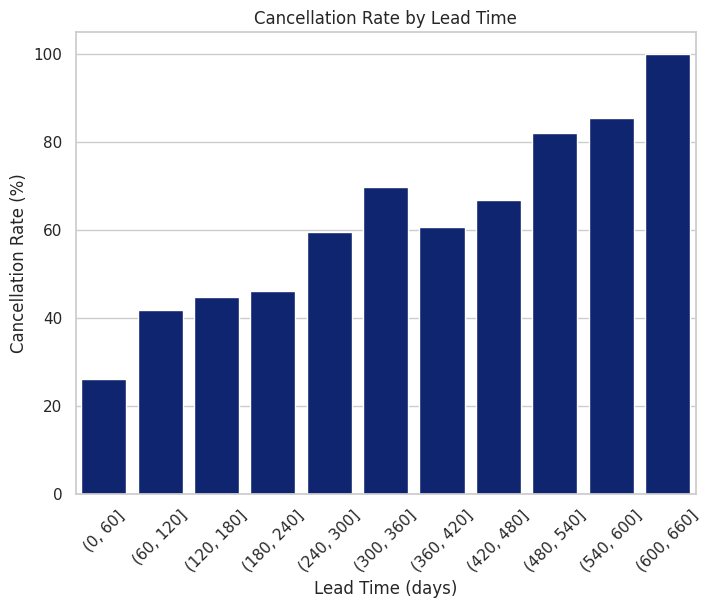

In [50]:
sns.set(style="whitegrid")
sns.set_palette("dark")
# Define bins for lead time
bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660]

# Add a new column for lead time category
hotel_data['lead_time_category'] = pd.cut(hotel_data['lead_time'], bins)

# Calculate overall cancellation rate for each lead time category
cancellation_rates = hotel_data.groupby('lead_time_category')['is_canceled'].mean() * 100

# Plot cancellation rates
plt.figure(figsize=(8, 6))
sns.barplot(x=cancellation_rates.index, y=cancellation_rates.values)
plt.title('Cancellation Rate by Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.show()


Previous graph suggests that there is a positive relationship between the lead time and cancellation. The longer the time between booking and actual stay, the more likely the booking is to be cancelled.

Lets run a hypothesis test to find if there is an association between 'lead time' and 'cancellation'. In other words, the cancellation of a booking depends on the the lead time.

Null Hypothesis H0: The lead_time and is_canceled are independent.

Alternative Hypothesis H1: The lead_time and is_canceled are not independent.

In [51]:
# Create a contingency table
contingency_table = pd.crosstab(hotel_data['lead_time'], hotel_data['is_canceled'])

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test statistic:",chi2)
print("p-value:",p)
#chi2, p

Chi-square test statistic: 18123.22034174444
p-value: 0.0


* The Chi-square test statistic is approximately 18123.22, indicating a significant difference between observed and expected frequencies.
* A higher Chi-Square statistic suggests a stronger relationship between variables.
* In hypothesis testing, a p-value below 0.05 leads to rejecting the null hypothesis.
* The obtained p-value is 0.0, so we reject the null hypothesis (H0: Lead time does not affect cancellation rate).
* The alternative hypothesis (H1: Lead time affects cancellation rate) is supported by statistical evidence.
* This finding aligns with our earlier observation from the bar chart, confirming that cancellation rates increase with lead time.

# **Recommendations:**
1. Target Marketing Strategies:
Given the higher cancellation rates in Portugal, focus on targeted marketing efforts in this region. Conduct surveys to understand customer concerns and tailor marketing strategies to address these issues. Implement customer-centric promotions and services to enhance satisfaction and reduce cancellations.

2. Dynamic Pricing and Lead Time Reduction:
Utilize a dynamic pricing model to encourage last-minute bookings and reduce lead time. Offer incentives for shorter booking windows to align with the observed relationship between lead time and cancellation rates. This strategy can optimize revenue and minimize cancellations.

3. Invest in Customer Loyalty and Flexible Plans:
Implement loyalty programs to enhance customer loyalty and reduce cancellations. Additionally, introduce flexible booking options, such as free cancellations up to a certain period, to give guests more confidence in their reservations and decrease cancellation likelihood.

4. Seasonal Pricing Strategies:
Leverage the observed seasonal fluctuations by adjusting pricing strategies. Increase Average Daily Rates (ADR) during peak booking seasons, especially in August, to maximize revenue. Conversely, consider offering competitive rates during lower demand periods to attract more bookings.

5. Cancellation Prevention Investments:
Allocate resources to improve the booking process, enhance customer service, and implement flexible cancellation policies. Investing in cancellation prevention measures can lead to a significant increase in revenue, as indicated by the analysis of ADR for canceled bookings.


# **Conclusion**
In conclusion, the comprehensive analysis reveals valuable insights into booking patterns, cancellations, and Average Daily Rates. The identified strategies aim to address specific challenges associated with cancellation rates, market variations, and seasonal demand. By implementing targeted marketing, dynamic pricing, loyalty programs, and cancellation prevention measures, the hotel can optimize revenue and enhance customer satisfaction.

The observed relationship between lead time and cancellation emphasizes the importance of strategies to minimize the booking window. These recommendations, grounded in data-driven insights, provide a roadmap for the hotel to navigate market dynamics effectively.

In essence, by adopting these recommendations, the hotel can not only mitigate the impact of cancellations but also capitalize on opportunities to increase revenue, improve customer loyalty, and maintain a competitive edge in the hospitality industry.